# Baseline Model for Animal Image Classification

## Setup and Import Required Libraries

In [35]:
# Importing libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
import sys
import os

# Determine the project root directory
if '__file__' in globals():
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
else:
    # Manually set the project root if __file__ is not defined (e.g., in Jupyter notebook)
    project_root = os.path.abspath('..')
sys.path.append(project_root)

from models.baseline_cnn import BaselineCNN
from src.device_manager import DeviceDataLoader, get_default_device, to_device
from src.train import fit
from src.evaluate import evaluate
from src.plot import plot_losses, plot_accuracies
from src.FLOPs_counter import print_model_parm_flops

## Load Data

In [38]:
data_dir = '../dataset/animals/'
classes = os.listdir(data_dir)

In [39]:
# Image Transformations
transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

# Load Data
dataset = ImageFolder(data_dir, transform=transform)

print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [40]:
# Splitting the dataset to training, validation, and testing category
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print('Size of training dataset:', len(train_ds))
print('Size of validation dataset:', len(val_ds))
print('Size of test dataset:', len(test_ds))

Size of training dataset: 5330
Size of validation dataset: 313
Size of test dataset: 627


In [41]:
# Data loaders
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

## Data Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2467773..2.3572743].


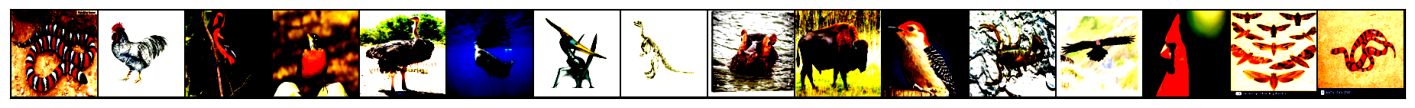

In [42]:
# Preview multiple images
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [43]:
# Count the number of samples in each class
class_count = {}
for images, label in train_ds:
    class_count[classes[label]] = class_count.get(classes[label], 0) + 1

print("Number of samples in each class:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

Number of samples in each class:
phoebetria-fusca: 45
smilodon-populator: 40
ovis-canadensis: 41
okapia-johnstoni: 24
spheniscus-demersus: 28
ophiophagus-hannah: 29
ailurus-fulgens: 26
icterus-gularis: 43
triceratops-horridus: 23
equus-caballus: 27
cyanocitta-cristata: 31
acinonyx-jubatus: 43
physeter-macrocephalus: 40
hydrurga-leptonyx: 42
phoenicopterus-ruber: 45
periplaneta-americana: 42
megaptera-novaeangliae: 51
circus-hudsonius: 35
diplodocus: 28
odobenus-rosmarus: 39
vulpes-vulpes: 46
tyrannus-tyrannus: 39
lemur-catta: 54
apis-mellifera: 26
salmo-salar: 42
martes-americana: 40
mergus-serrator: 42
correlophus-ciliatus: 27
panthera-pardus: 25
mellisuga-helenae: 43
gorilla-gorilla: 28
crotalus-atrox: 44
cryptoprocta-ferox: 40
ankylosaurus-magniventris: 42
pteranodon-longiceps: 30
lepus-americanus: 26
gavialis-gangeticus: 46
monodon-monoceros: 47
turdus-migratorius: 24
.DS_Store: 32
danaus-plexippus: 54
struthio-camelus: 32
procyon-lotor: 25
pantherophis-alleghaniensis: 48
ornithorh

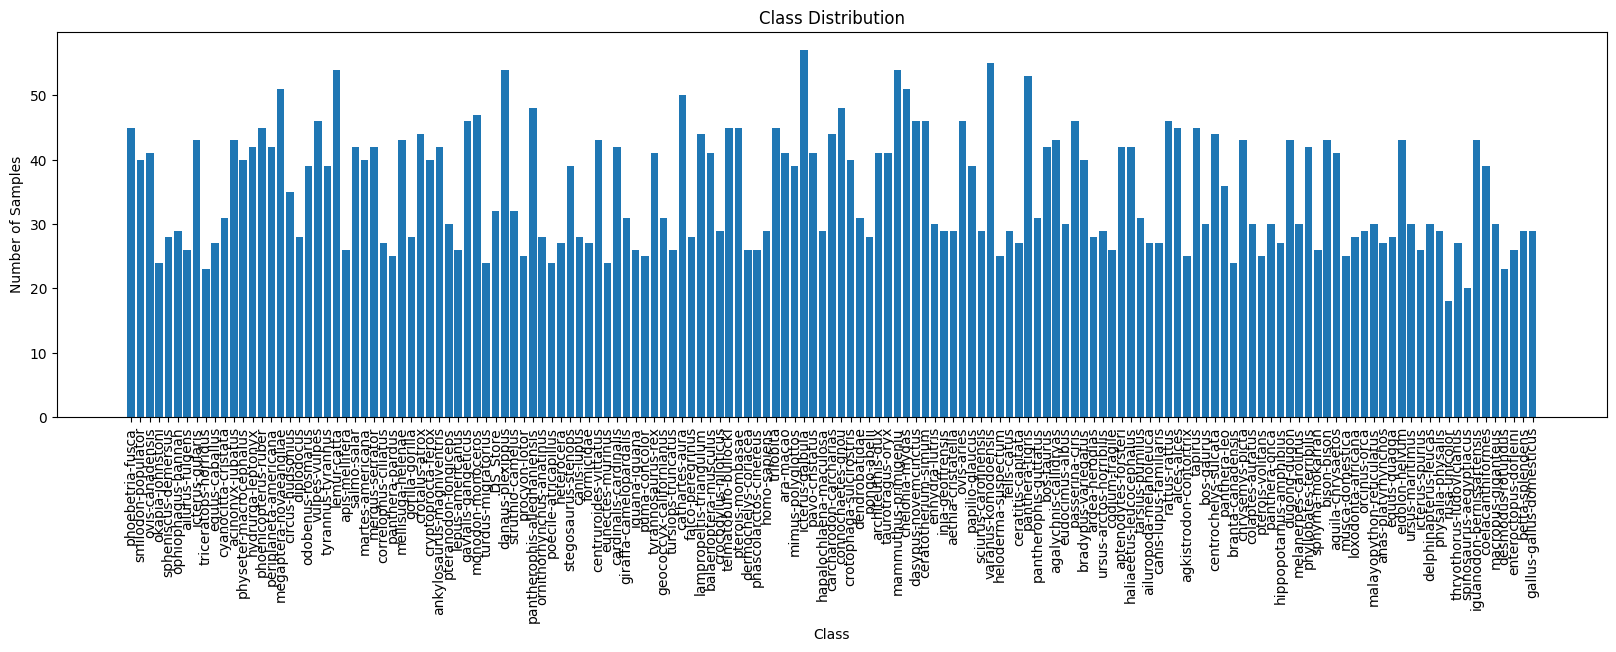

In [44]:
# Display the class distribution
plt.figure(figsize=(20, 5)) 
plt.bar(class_count.keys(), class_count.values())
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

In [45]:
# Calculate the mean, standard deviation, minimum, maximum, median, and quartiles of the number of samples in each class
sample_count = np.array(list(class_count.values())) 

mean_samples = sample_count.mean()
std_samples = sample_count.std()
min_samples = sample_count.min()
max_samples = sample_count.max()
median_samples = np.median(sample_count)
quarter_samples = np.percentile(sample_count, [25, 50, 75])

print("Mean samples:", mean_samples)
print("Standard deviation of samples:", std_samples)
print("Minimum samples:", min_samples)
print("First quartile samples (25%):", quarter_samples[0])
print("Median samples:", median_samples)
print("Third quartile samples (75%):", quarter_samples[2])
print("Maximum samples:", max_samples)

Mean samples: 35.29801324503311
Standard deviation of samples: 8.921136967591437
Minimum samples: 18
First quartile samples (25%): 28.0
Median samples: 31.0
Third quartile samples (75%): 43.0
Maximum samples: 57


In [46]:
# Move data to device (GPU or CPU)
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

## Model Initialization

In [47]:
num_classes = len(classes) # 151 classes

# Initialize the model
model = BaselineCNN(num_classes)
print(model)

BaselineCNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=152, bias=True)
)


In [48]:
# Move model to the device
model = to_device(model, device)

## Model Training

In [49]:
# Evaluate the model before training
history = [evaluate(model, val_dl)]
history_not_trained = history
print("Before training: ", history_not_trained)

Before training:  [{'val_loss': 5.026598930358887, 'val_acc': 0.01875000074505806}]


In [50]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

# Train the model
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████| 334/334 [00:03<00:00, 83.51it/s]


Epoch [0], train_loss: 4.8140, val_loss: 4.5290, val_acc: 0.1042


100%|██████████| 334/334 [00:04<00:00, 79.33it/s]


Epoch [1], train_loss: 4.1742, val_loss: 4.1482, val_acc: 0.2135


100%|██████████| 334/334 [00:04<00:00, 77.85it/s]


Epoch [2], train_loss: 3.6289, val_loss: 3.8742, val_acc: 0.2872


100%|██████████| 334/334 [00:04<00:00, 81.20it/s]


Epoch [3], train_loss: 3.1817, val_loss: 3.8492, val_acc: 0.3309


100%|██████████| 334/334 [00:04<00:00, 78.14it/s]


Epoch [4], train_loss: 2.7580, val_loss: 3.9623, val_acc: 0.3340


100%|██████████| 334/334 [00:04<00:00, 77.78it/s]


Epoch [5], train_loss: 2.4114, val_loss: 3.8722, val_acc: 0.3653


100%|██████████| 334/334 [00:04<00:00, 77.56it/s]


Epoch [6], train_loss: 2.0636, val_loss: 4.2142, val_acc: 0.3597


100%|██████████| 334/334 [00:04<00:00, 81.73it/s]


Epoch [7], train_loss: 1.7693, val_loss: 4.5020, val_acc: 0.3764


100%|██████████| 334/334 [00:03<00:00, 83.81it/s]


Epoch [8], train_loss: 1.4536, val_loss: 5.1403, val_acc: 0.3372


100%|██████████| 334/334 [00:04<00:00, 77.49it/s]


Epoch [9], train_loss: 1.2221, val_loss: 5.5807, val_acc: 0.3490


In [51]:
# Save training history
torch.save(history, '../results/baseline_cnn_history.pth')

In [52]:
# Save the model
torch.save(model.state_dict(), '../results/baseline_cnn.pth')

## Model Evaluation

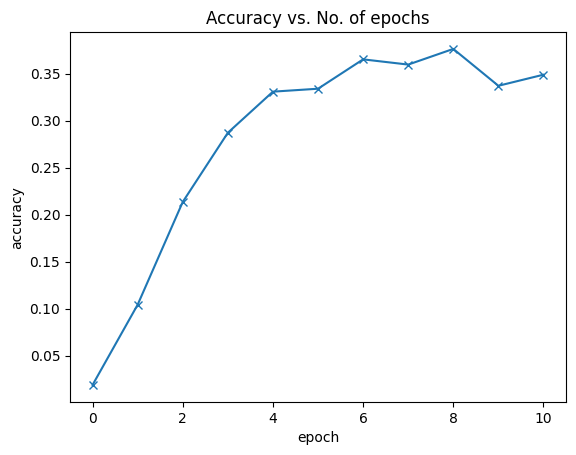

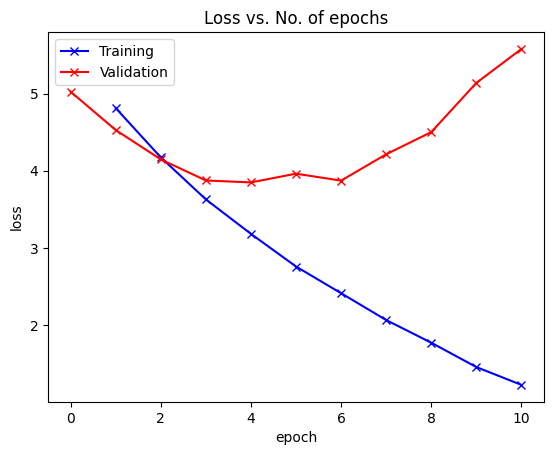

In [53]:
# Plot the accuracies and losses
plot_accuracies(history)
plot_losses(history)

In [54]:
# Evaluate the model after training
val = evaluate(model, test_dl)
print("Accuracy:", val['val_acc'])

Accuracy: 0.37708336114883423


In [55]:
# Number of FLOPs
input = torch.randn(1, 3, 112, 112).to(device)
flops = print_model_parm_flops(model, input, detail=True)

Number of FLOPs: 0.689651712
Conv FLOPs: 0.688678912
Linear FLOPs: 0.0009728
Batch Norm FLOPs: 0.0
ReLU FLOPs: 0.0
Pooling FLOPs: 0.0
